# 3.5 뉴스 기사 분류 : 다중 분류 문제

### 3.5.1 로이터 데이터셋

- 1986년에 로이터에서 공개한 데이터셋이며 텍스트 분류에 널리 사용됨
- 짧은 뉴스 기사와 46개의 서로다른 topic의 집합

In [1]:
# 케라스에 내장된 로이터 데이터셋 로드하기
from keras.datasets import reuters

# 3.4절과 마찬가지로 num_words=10000은 자주 사용되는 단어 10000개로 제한한다는 의미
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

Using TensorFlow backend.


(8982,) (8982,)
(2246,) (2246,)


In [2]:
# 로이터 데이터셋 내용 확인
word_index = reuters.get_word_index()
index_word = dict([(index, word) for (word, index) in word_index.items()])

decoded = ' '.join(index_word.get(i-3, '?') for i in train_data[0])
print(decoded)

? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


### 3.5.2 데이터 준비

- 데이터를 벡터로 변환
- 레이블을 one-hot encoding

In [3]:
import numpy as np

# data -> vector
def vectorize_sequences(sequences, dimension=10000):
    result = np.zeros((len(sequences), dimension))
    for i, seq in enumerate(sequences):
        result[i, seq] = 1.
    
    return result


# one-hot encoding
# from keras.utils.np_utils import to_categorical()을 이용할수도 잇음
def one_hot_encoding(labels, num_classes=46):
    result = np.zeros((len(labels), num_classes))
    for i, label in enumerate(labels):
        result[i, label] = 1
    
    return result
                      
            
train_data = vectorize_sequences(train_data)
train_labels = one_hot_encoding(train_labels)
test_data = vectorize_sequences(test_data)
test_labels = one_hot_encoding(test_labels)

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(8982, 10000) (8982, 46)
(2246, 10000) (2246, 46)


### 3.5.3 모델 구성

- Dense(64)
    - 출력 클래스의 개수가 2개에서 46개로 늘어났는데 3.4절의 이진 분류처럼(Dense(16), 16차원의 공간) Dense layer를 쌓게되면 충분한 정보가 저장되지 않음
    - **64개의 유닛(64차원의 공간)을 사용**

- 마지막 layer
    - 총 46개의 class에 대한 확률을 알아내야 하므로 Dense(46)을 사용
    - 각 class별 확률이 나오는 softmax 활성화 함수를 사용
    - softmax로 나온 output의 46개 값을 모두 더하면 1

- loss function
    - multiclass classification과 같은 문제에서는 주로 categorical_crossentropy를 사용함

In [4]:
from keras import models
from keras import layers

# 출력 : 46(class의 수)
# 활성화 함수 : softmax
# 손실 함수 : categorical_crossentropy

model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.summary()

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


### 3.5.4 훈련 검증

train data에서 1000개의 sample을 validation data로 사용

In [5]:
val_data = train_data[:1000]
train_data = train_data[1000:]

val_labels = train_labels[:1000]
train_labels = train_labels[1000:]

print(train_data.shape, train_labels.shape)
print(val_data.shape, val_labels.shape)

(7982, 10000) (7982, 46)
(1000, 10000) (1000, 46)


In [6]:
# 20번의 epoch로 training

hist = model.fit(train_data, train_labels,
                 epochs=20,
                 batch_size=512,
                 validation_data=(test_data, test_labels))

Train on 7982 samples, validate on 2246 samples
Epoch 1/20
7982/7982 [==============================] - 0s 61us/step - loss: 2.4546 - accuracy: 0.5639 - val_loss: 1.6884 - val_accuracy: 0.6638
Epoch 2/20
7982/7982 [==============================] - 0s 46us/step - loss: 1.3657 - accuracy: 0.7147 - val_loss: 1.3536 - val_accuracy: 0.7004
Epoch 3/20
7982/7982 [==============================] - 0s 44us/step - loss: 1.0365 - accuracy: 0.7800 - val_loss: 1.2296 - val_accuracy: 0.7418
Epoch 4/20
7982/7982 [==============================] - 0s 43us/step - loss: 0.8174 - accuracy: 0.8292 - val_loss: 1.1014 - val_accuracy: 0.7565
Epoch 5/20
7982/7982 [==============================] - 0s 42us/step - loss: 0.6494 - accuracy: 0.8647 - val_loss: 1.0397 - val_accuracy: 0.7680
Epoch 6/20
7982/7982 [==============================] - 0s 42us/step - loss: 0.5153 - accuracy: 0.8931 - val_loss: 1.0252 - val_accuracy: 0.7711
Epoch 7/20
7982/7982 [==============================] - 0s 43us/step - loss: 0.415

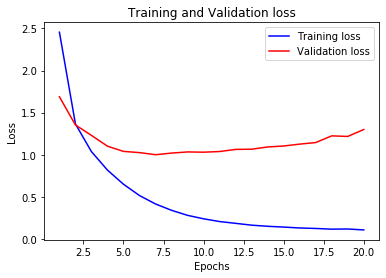

In [7]:
import matplotlib.pyplot as plt

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label="Training loss")
plt.plot(epochs, val_loss, 'r', label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

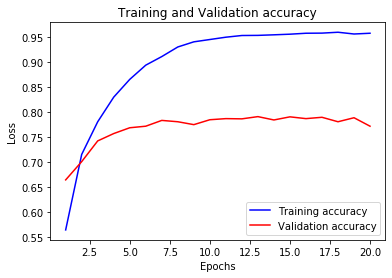

In [8]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label="Training accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [9]:
result = model.evaluate(val_data, val_labels)
print("loss : ", result[0], ", accuracy : ", result[1])

1000/1000 [==============================] - 0s 55us/step
loss :  1.1568426761627197 , accuracy :  0.7860000133514404


- 약 9번째 epoch 이후부터 overfitting이 일어남
- epoch을 9로 놓고 다시 테스트

In [10]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

hist = model.fit(train_data, train_labels,
                 epochs=9, batch_size=512,
                 validation_data=(test_data, test_labels))

Train on 7982 samples, validate on 2246 samples
Epoch 1/9
7982/7982 [==============================] - 0s 50us/step - loss: 2.6673 - accuracy: 0.5208 - val_loss: 1.8073 - val_accuracy: 0.6376
Epoch 2/9
7982/7982 [==============================] - 0s 46us/step - loss: 1.4529 - accuracy: 0.6984 - val_loss: 1.3997 - val_accuracy: 0.6834
Epoch 3/9
7982/7982 [==============================] - 0s 48us/step - loss: 1.0769 - accuracy: 0.7720 - val_loss: 1.2282 - val_accuracy: 0.7266
Epoch 4/9
7982/7982 [==============================] - 0s 48us/step - loss: 0.8431 - accuracy: 0.8269 - val_loss: 1.1042 - val_accuracy: 0.7551
Epoch 5/9
7982/7982 [==============================] - 0s 50us/step - loss: 0.6724 - accuracy: 0.8598 - val_loss: 1.0351 - val_accuracy: 0.7738
Epoch 6/9
7982/7982 [==============================] - 0s 48us/step - loss: 0.5383 - accuracy: 0.8899 - val_loss: 0.9922 - val_accuracy: 0.7787
Epoch 7/9
7982/7982 [==============================] - 0s 44us/step - loss: 0.4300 - acc

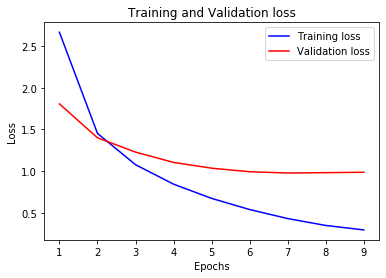

In [12]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label="Training loss")
plt.plot(epochs, val_loss, 'r', label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

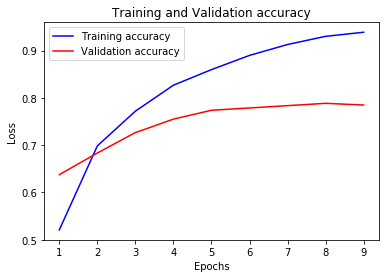

In [13]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label="Training accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [14]:
result = model.evaluate(val_data, val_labels)
print("loss : ", result[0], ", accuracy : ", result[1])

1000/1000 [==============================] - 0s 41us/step
loss :  0.8930388917922973 , accuracy :  0.8190000057220459


### 3.5.5 새로운 데이터에 대해 예측하기

predict()를 통해 46개의 class에 대한 확률 분포를 출력

In [15]:
prediction = model.predict(train_data)

# prediction의 각 항목은 길이가 46인 벡터
print(prediction[0].shape)

# 모든 원소의 합은 1
print(np.sum(prediction[0]))

# 가장 큰 값이 예측값이됨
print(np.argmax(prediction[0]))

(46,)
1.0
19


### 3.5.6 레이블과 손실을 다루는 다른 방법

- 레이블 인코딩 방법
    1. one-hot encoding (범주형, loss=categorical_crossentropy)
    2. 정수 텐서를 이용하는방법 (정수형, loss=sparse_categorical_crossentropy)
    
    
categorical_crossentropy와 sparse_categorical_crossentropy는 인터페이스만 다를 뿐 수학적으로 동일함

In [16]:
# 2. 정수 텐서 이용방법 예
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

# 아래처럼 label을 numpy array로 바꾸고 loss='sparse_categorical_crossentropy'를 사용하면 됨
# 여기서는 이미 numpy array이지만 numpy array여야 한다는 것을 나타내기 위함
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

### 3.5.7 충분히 큰 중간층(hidden layer)을 두어야 하는 이유

- 마지막 출력이 46차원이기 때문에 hidden layer는 46차원보다 많이 적어서는 안됨
- 46차원보다 훨씬 적은 hidden layer를 두면 정보의 병목(information bottleneck)이 일어남
- information bottleneck
    - 각 층은 이전 층의 output으로부터 정보를 받음
    - 한 층이 일부 정보를 누락하면 그 다음 층에서 복원할 방법이 없음
    - 각 층은 잠재적으로 information bottleneck이 될 수 있음
    - 따라서, **출력의 차원보다 많이 적지 않도록 layer를 구성해 information bottleneck을 방지해야함**

In [17]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

train_data = vectorize_sequences(train_data)
test_data = vectorize_sequences(test_data)

# 정수 텐서 방법 사용해봄
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

val_data = train_data[:1000]
train_data = train_data[1000:]
val_labels = train_labels[:1000]
train_labels = train_labels[1000:]

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)
print(val_data.shape, val_labels.shape)

# information bottleneck이 있는 model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.summary()

(7982, 10000) (7982,)
(2246, 10000) (2246,)
(1000, 10000) (1000,)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 46)                782       
Total params: 641,886
Trainable params: 641,886
Non-trainable params: 0
_________________________________________________________________


In [18]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='RMSprop',
              metrics=['accuracy'])

hist = model.fit(train_data, train_labels,
                 epochs=9, batch_size=512,
                 validation_data=(test_data, test_labels))

Train on 7982 samples, validate on 2246 samples
Epoch 1/9
7982/7982 [==============================] - 1s 63us/step - loss: 3.1064 - accuracy: 0.4063 - val_loss: 2.3937 - val_accuracy: 0.5895
Epoch 2/9
7982/7982 [==============================] - 0s 43us/step - loss: 1.9304 - accuracy: 0.6468 - val_loss: 1.6997 - val_accuracy: 0.6674
Epoch 3/9
7982/7982 [==============================] - 0s 42us/step - loss: 1.3679 - accuracy: 0.7471 - val_loss: 1.4056 - val_accuracy: 0.7102
Epoch 4/9
7982/7982 [==============================] - 0s 42us/step - loss: 1.0762 - accuracy: 0.7884 - val_loss: 1.2642 - val_accuracy: 0.7297
Epoch 5/9
7982/7982 [==============================] - 0s 42us/step - loss: 0.8940 - accuracy: 0.8181 - val_loss: 1.1873 - val_accuracy: 0.7493
Epoch 6/9
7982/7982 [==============================] - 0s 42us/step - loss: 0.7599 - accuracy: 0.8413 - val_loss: 1.1321 - val_accuracy: 0.7578
Epoch 7/9
7982/7982 [==============================] - 0s 42us/step - loss: 0.6531 - acc

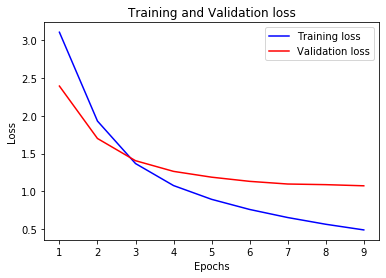

In [19]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label="Training loss")
plt.plot(epochs, val_loss, 'r', label="Validation loss")
plt.title("Training and Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

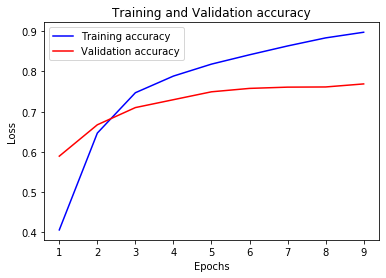

In [20]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'b', label="Training accuracy")
plt.plot(epochs, val_acc, 'r', label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [21]:
result = model.evaluate(val_data, val_labels)
print("loss : ", result[0], ", accuracy : ", result[1])

1000/1000 [==============================] - 0s 53us/step
loss :  0.9723118534088134 , accuracy :  0.7990000247955322


- accuracy가 약간 감소함
- 이는 많은 정보(클래스 46개의 분할 초평면을 복원하기에 충분한 정보)를 중간층의 저차원 표현 공간으로 압축했기 때문
- **정보의 병목을 생각하면서 layer를 구성하자!**

### 3.5.8 정리

- N개의 클래스의 분류 문제에서는 마지막 층이 N개의 Dense layer
- 단일 레이블, 다중 분류 문제에서는 N개의 클래스에 대한 확률 분포를 위한 softmax 활성화 함수를 사용
- 이러한 문제에서는 범주형 크로스엔트로피(categorical_crossentropy)를 사용
- 다중 분류 문제에서의 레이블을 다루는 두가지 방법
    1. 레이블을 one-hot encoding 후 categorical_crossentropy 손실 함수 사용
    2. 레이블을 정수로 인코딩 후 sparse_categorical_crossentropy 손실 함수 사용
- 많은 수의 범주를 분류할 때, hidden layer(중간층)의 크기가 작으면 정보의 병목이 발생하므로 작지 않도록 해야 함